# Fantastic Four Final Project Code
# https://www.kaggle.com/c/titanic/overview

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Add dummy columns for Sex, Embarked
sex_dummies = pd.get_dummies(train['Sex'], drop_first = True)
sex_dummies.columns = ['Sex_male']

embarked_dummies = pd.get_dummies(train['Embarked'], drop_first = True)
embarked_dummies.columns = ['Embarked_Q', 'Embarked_S']

pclass_dummies = pd.get_dummies(train['Pclass'], drop_first = True)
pclass_dummies.columns = ['Pclass_2', 'Pclass_3']
train = pd.concat([train, pclass_dummies,sex_dummies, embarked_dummies], axis = 1)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,0,1,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,1,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,0,1,0,0


In [4]:
# Imputing for missing values in test data
test.replace('?', np.nan, inplace=True)
avg_age = test['Age'].astype('float').mean(axis=0)
test['Age'].replace(np.nan,avg_age,inplace= True)
avg_fare = test['Fare'].astype('float').mean(axis=0)
test['Fare'].replace(np.nan,avg_fare,inplace= True)

In [5]:
def jitter(values, j):
    return values + np.random.normal(j, 0.02, values.shape)

def confusion_matrix_train(model, cutoff=0.5):
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    return cm_df, accuracy

def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    return cm_df, accuracy

### Check collinearity

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [7]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.000086,-0.029486,0.042939,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.093349,-0.322308,-0.543351,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.188432,0.916673,0.131900,0.221009,0.081720
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.006954,-0.312271,0.093254,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.055932,0.092548,-0.114631,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.000734,0.015790,-0.245489,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.118557,-0.413333,-0.182333,-0.117216,-0.166603
Pclass_2,-0.000086,0.093349,-0.188432,0.006954,-0.055932,-0.000734,-0.118557,1.000000,-0.565210,-0.064746,-0.127301,0.192061
Pclass_3,-0.029486,-0.322308,0.916673,-0.312271,0.092548,0.015790,-0.413333,-0.565210,1.000000,0.137143,0.237449,-0.009511
Sex_male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,-0.064746,0.137143,1.000000,-0.074115,0.125722


In [8]:
X = train[['PassengerId','Age','SibSp','Parch','Fare','Pclass','Sex_male','Embarked_Q','Embarked_S']].dropna()
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)
vif_data
# Not a lot of collinearity between predictors

,feature,VIF
0,const,35.628039
1,PassengerId,1.009271
2,Age,1.317764
3,SibSp,1.291895
4,Parch,1.290717
5,Fare,1.645918
6,Pclass,1.798871
7,Sex_male,1.123023
8,Embarked_Q,1.247670
9,Embarked_S,1.323977


### Examining `Age`

<AxesSubplot:xlabel='Age', ylabel='Survived'>

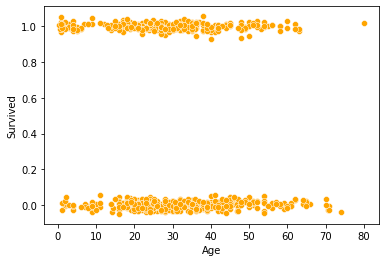

In [9]:
sns.scatterplot(data = train, x = jitter(train['Age'],0), y = jitter(train['Survived'],0), color = 'orange')

<AxesSubplot:xlabel='Survived', ylabel='Age'>

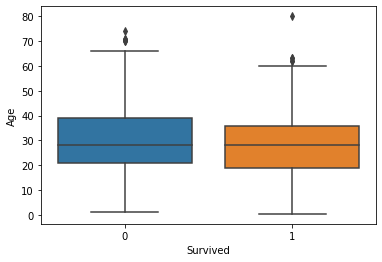

In [10]:
sns.boxplot(data = train, x = 'Survived', y = 'Age')

### Examining `Fare`

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

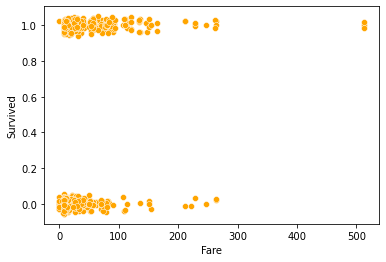

In [11]:
sns.scatterplot(data = train, x = jitter(train['Fare'],0), y = jitter(train['Survived'],0), color = 'orange')

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

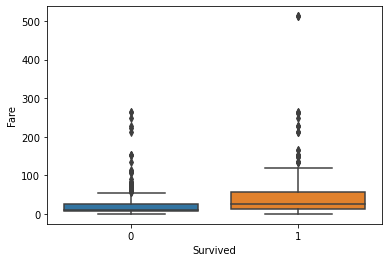

In [12]:
sns.boxplot(data = train, x = 'Survived', y = 'Fare')

### Examining `Pclass`

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

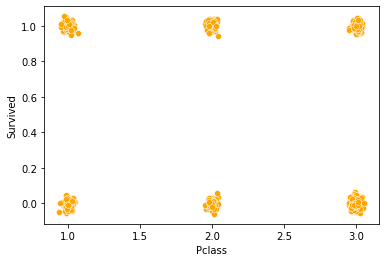

In [13]:
sns.scatterplot(data = train, x = jitter(train['Pclass'],0), y = jitter(train['Survived'],0), color = 'orange')

<AxesSubplot:xlabel='Survived', ylabel='Pclass'>

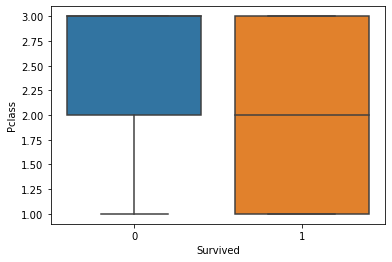

In [14]:
sns.boxplot(data = train, x = 'Survived', y = 'Pclass')

## First Model Attempt

In [15]:
# INITIAL MODEL
logit_model = sm.logit(formula = 'Survived~Age+Fare+Pclass+Sex', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.453242
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3290
Time:                        12:56:45   Log-Likelihood:                -323.61
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 2.020e-67
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9880      0.572      8.717      0.000       3.867       6.110
Sex[T.male]    -2.5182      0.208    -12.115      0.000      -2.926      -2.111
Age            -0.0367      0.008     -4.780      0.000      -0.052      -0.022
Fare            0.0005      0.002      0.246      0.805      -0.004       0.005
Pclass         -1.2697      0.159     -8.005      0.000      -1.581      -0.959
===============================================================================
"""

In [16]:
test_copy = test.copy()
pred_values = logit_model.predict(test_copy)
test_copy['pred_values'] = pred_values
test_copy['Survived'] = np.where(test_copy['pred_values'] < 0.5, 0, 1)

In [17]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        357.0         67.0
 Actual 1         81.0        209.0,
 79.27170868347339)

## Additional Models

In [18]:
# All predictors
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Fare+Sex+SibSp+Parch+Embarked', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.444061
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            8
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3419
Time:                        12:56:45   Log-Likelihood:                -316.17
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 3.392e-66
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.6374      0.635      8.884      0.000       4.394       6.881
Sex[T.male]      -2.6385      0.222    -11.871      0.000      -3.074      -2.203
Embarked[T.Q]    -0.8235      0.600     -1.372      0.170      -2.000       0.353
Embarked[T.S]    -0.4012      0.270     -1.484      0.138      -0.931       0.129
Age              -0.0433      0.008     -5.266      0.000      -0.059      -0.027
Pclass           -1.1993      0.165     -7.285      0.000      -1.522      -0.877
Fare              0.0014      0.003      0.566      0.572      -0.004       0.006
SibSp            -0.3632      0.129     -2.815      0.005      -0.616      -0.110
Parch            -0.0603      0.124     -0.486      0.627      -0.303       0.183
=================================================================================
"""

In [19]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        365.0         59.0
 Actual 1         83.0        205.0,
 80.0561797752809)

In [20]:
# Removed Embarked, Fare, and Parch because p-values are insignificant
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.445882
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3399
Time:                        12:56:45   Log-Likelihood:                -318.36
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.089e-69
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.6008      0.543     10.306      0.000       4.536       6.666
Sex[T.male]    -2.6235      0.215    -12.229      0.000      -3.044      -2.203
Age            -0.0444      0.008     -5.442      0.000      -0.060      -0.028
Pclass         -1.3174      0.141     -9.350      0.000      -1.594      -1.041
SibSp          -0.3761      0.121     -3.106      0.002      -0.613      -0.139
===============================================================================
"""

In [21]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        365.0         59.0
 Actual 1         78.0        212.0,
 80.812324929972)

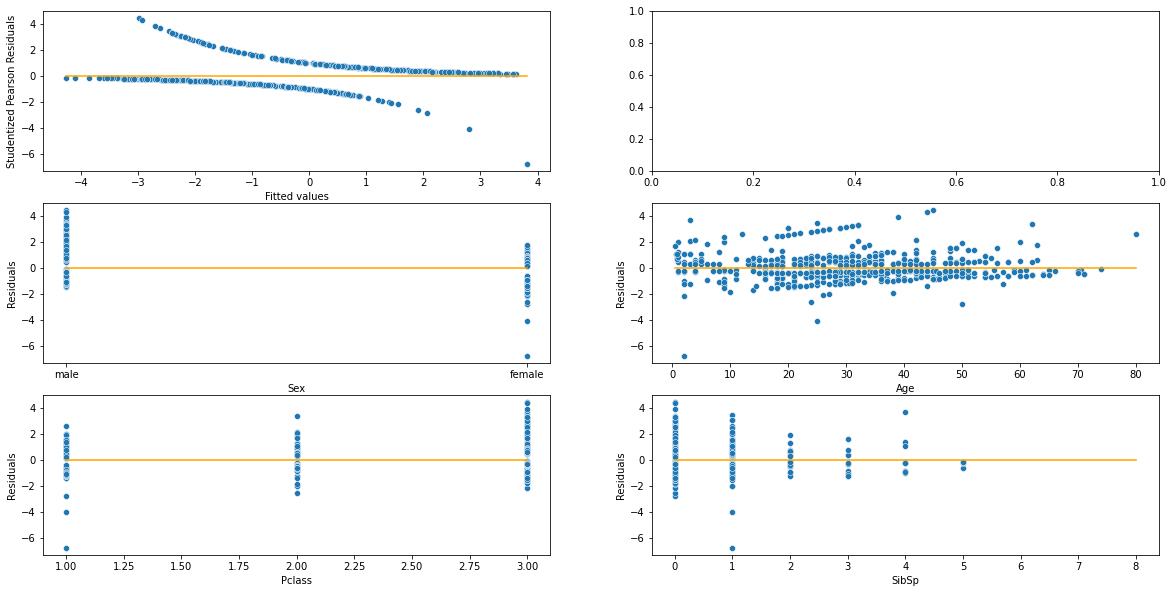

In [22]:
# Check for linearity and constant variance
fig, axes = plt.subplots(3, 2, figsize=(20, 10))

# Residuals vs. Fitted values
sns.scatterplot(ax = axes[0,0], x = logit_model.fittedvalues, y = logit_model.resid_pearson)
sns.lineplot(ax = axes[0,0], x = logit_model.fittedvalues, y = 0, 
             color = 'orange')
axes[0,0].set_xlabel('Fitted values')
axes[0,0].set_ylabel('Studentized Pearson Residuals')

# Residuals vs. feature variables
feature_vars = ['Age', 'Pclass', 'SibSp', 'Sex']
for i in range(4):
    curr_axes = axes[i//2+1, i%2]
    curr_feature = feature_vars[i-1]
    sns.scatterplot(ax = curr_axes, x = train[curr_feature], y = logit_model.resid_pearson)
    sns.lineplot(ax = curr_axes, x = train[curr_feature], y = 0, 
                 color = 'orange')
    curr_axes.set_xlabel(feature_vars[i-1])
    curr_axes.set_ylabel('Residuals')

<AxesSubplot:xlabel='Age', ylabel='Survived'>

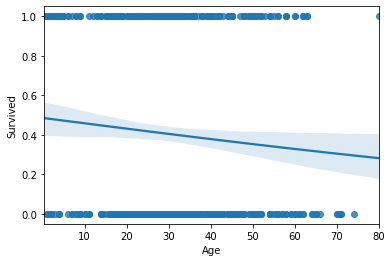

In [23]:
# supposed to look like an S curve??
# Predictors should be linear with log odds of response
sns.regplot(x= 'Age', y= 'Survived', data= train, logistic= True)

In [24]:
# Transform np.exp(SibSp)
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+np.exp(SibSp)', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.444555
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3418
Time:                        12:57:03   Log-Likelihood:                -317.41
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 4.247e-70
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.4004      0.523     10.322      0.000       4.375       6.426
Sex[T.male]      -2.5713      0.211    -12.161      0.000      -2.986      -2.157
Age              -0.0438      0.008     -5.417      0.000      -0.060      -0.028
Pclass           -1.2744      0.140     -9.115      0.000      -1.548      -1.000
np.exp(SibSp)    -0.0390      0.014     -2.752      0.006      -0.067      -0.011
=================================================================================
"""

In [25]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        362.0         62.0
 Actual 1         77.0        213.0,
 80.53221288515407)

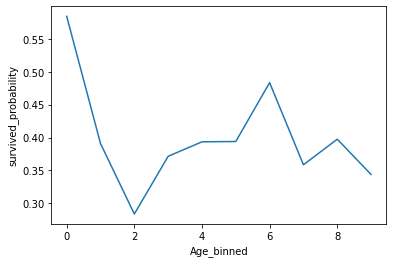

In [26]:
### Bin Age, Fare

# Bin Age
binned_age = pd.qcut(train['Age'], 10, retbins = True)
train['age_binned'] = binned_age[0]
age_data = train.groupby('age_binned')['Survived'].agg([('survived_probability','mean'),('nobs','count')]).reset_index(drop = False)
sns.lineplot(x = age_data.index, y = age_data['survived_probability'])
plt.xlabel('Age_binned')
plt.savefig('age_binned_vs_survival')

In [27]:
def var_transform(new_data):
    binned_age = pd.qcut(train['Age'], 10, retbins = True) #can modify model by changing # of bins
    bins = binned_age[1] # get cutoffs for each bin
    new_data['age_binned'] = pd.cut(new_data['Age'], bins = bins)
    dum = pd.get_dummies(new_data['age_binned'], drop_first = True) #drop first dummy var cuz we only need n-1 to avoid multicollinearity
    dum.columns = ['age' + str(i) for i in range(1, len(bins)-1)] #rename columns so Python can read them
    new_data = pd.concat([new_data, dum], axis = 1)
    return new_data

binned_age_train = var_transform(train)
logit_model = sm.logit(formula = 'Survived ~ ' + '+'.join(['age' + str(i) for i in range(1, 10-1)]), 
                        data = binned_age_train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.661903
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                0.006020
Time:                        12:57:04   Log-Likelihood:                -589.76
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                    0.5212
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5142      0.116     -4.437      0.000      -0.741      -0.287
age1           0.0702      0.248      0.283      0.777      -0.417       0.557
age2          -0.4126      0.295     -1.400      0.162      -0.990       0.165
age3          -0.0119      0.273     -0.044      0.965      -0.547       0.523
age4           0.0813      0.287      0.284      0.777      -0.480       0.643
age5           0.0834      0.277      0.301      0.764      -0.460       0.627
age6           0.4482      0.240      1.870      0.061      -0.021       0.918
age7          -0.0677      0.309     -0.219      0.826      -0.673       0.538
age8           0.0980      0.259      0.379      0.705      -0.409       0.605
==============================================================================
"""

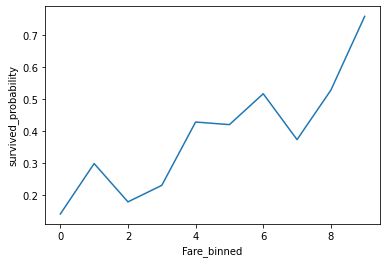

In [28]:
# Bin Fare
binned_fare = pd.qcut(train['Fare'], 10, retbins = True)
train['fare_binned'] = binned_fare[0]
fare_data = train.groupby('fare_binned')['Survived'].agg([('survived_probability','mean'),('nobs','count')]).reset_index(drop = False)
sns.lineplot(x = fare_data.index, y = fare_data['survived_probability'])
plt.xlabel('Fare_binned')
plt.savefig('fare_binned_vs_survival')

In [29]:
plt.savefig('fare_binned_vs_survival')

<Figure size 432x288 with 0 Axes>

In [30]:
logit_model = sm.logit(formula = 'Survived ~ fare_binned', 
                        data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.596148
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      881
Method:                           MLE   Df Model:                            9
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.1048
Time:                        12:57:04   Log-Likelihood:                -531.17
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.741e-22
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   -1.8045      0.299     -6.029      0.000      -2.391      -1.218
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.9517      0.380      2.504      0.012       0.207       1.697
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.2830      0.392      0.722      0.470      -0.485       1.051
fare_binned[T.Interval(8.05, 10.5, closed='right')]          0.6005      0.402      1.493      0.135      -0.188       1.389
fare_binned[T.Interval(10.5, 14.454, closed='right')]        1.5168      0.372      4.080      0.000       0.788       2.245
fare_binned[T.Interval(14.454, 21.679, closed='right')]      1.4836      0.369      4.020      0.000       0.760       2.207
fare_binned[T.Interval(21.679, 27.0, closed='right')]        1.8719      0.367      5.103      0.000       1.153       2.591
fare_binned[T.Interval(27.0, 39.688, closed='right')]        1.2878      0.370      3.485      0.000       0.564       2.012
fare_binned[T.Interval(39.688, 77.958, closed='right')]      1.9170      0.367      5.224      0.000       1.198       2.636
fare_binned[T.Interval(77.958, 512.329, closed='right')]     2.9496      0.390      7.557      0.000       2.185       3.715
============================================================================================================================
"""

In [31]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        443.0        106.0
 Actual 1        183.0        159.0,
 67.5645342312009)

In [32]:
# Add fare_binned to previous model with highest accuracy
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp+fare_binned', data = train).fit()
logit_model.summary()
# improves accuracy a little bit, but all fare_binned predictors are insignificant?

Optimization terminated successfully.
         Current function value: 0.437956
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3516
Time:                        12:57:04   Log-Likelihood:                -312.70
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.508e-64
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    5.5066      0.882      6.242      0.000       3.778       7.236
Sex[T.male]                                                 -2.6847      0.229    -11.745      0.000      -3.133      -2.237
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0615      0.569      0.108      0.914      -1.053       1.176
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7449      0.521      1.430      0.153      -0.276       1.765
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.3907      0.530     -0.738      0.461      -1.429       0.648
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.0719      0.507     -0.142      0.887      -1.066       0.922
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.5364      0.524      1.024      0.306      -0.491       1.563
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.5239      0.557      0.941      0.347      -0.567       1.615
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.1082      0.561     -0.193      0.847      -1.208       0.991
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.4170      0.615      0.678      0.498      -0.789       1.623
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.3007      0.666      0.452      0.651      -1.004       1.605
Age                                                         -0.0465      0.008     -5.503      0.000      -0.063      -0.030
Pclass                                                      -1.3061      0.229     -5.707      0.000      -1.755      -0.858
SibSp                                                       -0.4337      0.149     -2.912      0.004      -0.726      -0.142
============================================================================================================================
"""

In [33]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        368.0         56.0
 Actual 1         70.0        220.0,
 82.3529411764706)

In [34]:
# Use dummy vars for Pclass
logit_model = sm.logit(formula = 'Survived~Age+Pclass_2+Pclass_3+Sex+SibSp+fare_binned', data = train).fit()
logit_model.summary()
# same thing as just using Pclass and no dummy vars though

Optimization terminated successfully.
         Current function value: 0.437938
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      699
Method:                           MLE   Df Model:                           14
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3516
Time:                        12:57:04   Log-Likelihood:                -312.69
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 7.778e-64
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    4.1823      0.713      5.863      0.000       2.784       5.580
Sex[T.male]                                                 -2.6848      0.229    -11.738      0.000      -3.133      -2.237
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0591      0.569      0.104      0.917      -1.055       1.174
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7422      0.521      1.425      0.154      -0.278       1.763
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.4086      0.541     -0.755      0.450      -1.470       0.653
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.1010      0.538     -0.188      0.851      -1.156       0.954
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.5257      0.528      0.995      0.320      -0.510       1.561
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.5060      0.568      0.891      0.373      -0.607       1.619
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.1131      0.562     -0.201      0.840      -1.214       0.988
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.4201      0.615      0.683      0.495      -0.786       1.626
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.3137      0.670      0.468      0.640      -1.000       1.628
Age                                                         -0.0464      0.009     -5.442      0.000      -0.063      -0.030
Pclass_2                                                    -1.2530      0.401     -3.123      0.002      -2.039      -0.467
Pclass_3                                                    -2.5957      0.469     -5.534      0.000      -3.515      -1.676
SibSp                                                       -0.4349      0.149     -2.915      0.004      -0.727      -0.142
============================================================================================================================
"""

In [35]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        368.0         56.0
 Actual 1         70.0        220.0,
 82.3529411764706)

In [36]:
# Use dummy vars for Pclass, but remove fare_binned
logit_model = sm.logit(formula = 'Survived~Age+Pclass_2+Pclass_3+Sex+SibSp', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.445774
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3400
Time:                        12:57:05   Log-Likelihood:                -318.28
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 9.745e-69
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.3342      0.451      9.617      0.000       3.451       5.218
Sex[T.male]    -2.6277      0.215    -12.235      0.000      -3.049      -2.207
Age            -0.0448      0.008     -5.442      0.000      -0.061      -0.029
Pclass_2       -1.4144      0.285     -4.967      0.000      -1.972      -0.856
Pclass_3       -2.6526      0.286     -9.280      0.000      -3.213      -2.092
SibSp          -0.3802      0.122     -3.129      0.002      -0.618      -0.142
===============================================================================
"""

In [37]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        361.0         63.0
 Actual 1         78.0        212.0,
 80.25210084033614)

In [38]:
# Interaction between Age*fare_binned
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp+fare_binned+Age*fare_binned', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.426107
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      691
Method:                           MLE   Df Model:                           22
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3691
Time:                        12:57:05   Log-Likelihood:                -304.24
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 4.548e-62
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        9.0148      1.964      4.589      0.000       5.165      12.865
Sex[T.male]                                                     -2.7170      0.238    -11.426      0.000      -3.183      -2.251
fare_binned[T.Interval(7.55, 7.854, closed='right')]            -2.8556      2.057     -1.388      0.165      -6.888       1.177
fare_binned[T.Interval(7.854, 8.05, closed='right')]            -3.1450      1.945     -1.617      0.106      -6.957       0.667
fare_binned[T.Interval(8.05, 10.5, closed='right')]             -4.6454      1.810     -2.567      0.010      -8.192      -1.099
fare_binned[T.Interval(10.5, 14.454, closed='right')]           -2.1324      1.821     -1.171      0.242      -5.702       1.437
fare_binned[T.Interval(14.454, 21.679, closed='right')]         -1.7016      1.755     -0.970      0.332      -5.140       1.737
fare_binned[T.Interval(21.679, 27.0, closed='right')]           -1.8857      1.869     -1.009      0.313      -5.549       1.778
fare_binned[T.Interval(27.0, 39.688, closed='right')]           -2.7999      1.785     -1.569      0.117      -6.297       0.698
fare_binned[T.Interval(39.688, 77.958, closed='right')]         -3.1315      1.930     -1.623      0.105      -6.914       0.651
fare_binned[T.Interval(77.958, 512.329, closed='right')]        -4.3632      1.972     -2.213      0.027      -8.227      -0.499
Age                                                             -0.1673      0.068     -2.451      0.014      -0.301      -0.034
Age:fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.1205      0.084      1.430      0.153      -0.045       0.286
Age:fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.1567      0.077      2.023      0.043       0.005       0.309
Age:fare_binned[T.Interval(8.05, 10.5, closed='right')]          0.1646      0.072      2.299      0.022       0.024       0.305
Age:fare_binned[T.Interval(10.5, 14.454, closed='right')]        0.0840      0.073      1.156      0.248      -0.058       0.226
Age:fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.0895      0.072      1.248      0.212      -0.051       0.230
Age:fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.1007      0.070      1.430      0.153      -0.037       0.239
Age:fare_binned[T.Interval(27.0, 39.688, closed='right')]        0.1070      0.069      1.544      0.123      -0.029       0.243
Age:fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.1300      0.071      1.836      0.066      -0.009       0.269
Age:fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.1606      0.071      2.253      0.024       0.021       0.300
Pclass                                                          -1.4948      0.256     -5.847      0.000      -1.996      -0.994
SibSp           

In [39]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        373.0         51.0
 Actual 1         78.0        212.0,
 81.9327731092437)

In [40]:
# Interaction between Sex*fare_binned
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp+fare_binned+Sex*fare_binned', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.428829
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      691
Method:                           MLE   Df Model:                           22
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3651
Time:                        12:57:06   Log-Likelihood:                -306.18
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 2.846e-61
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                6.4395      1.352      4.764      0.000       3.790       9.089
Sex[T.male]                                                             -3.7933      1.210     -3.135      0.002      -6.165      -1.422
fare_binned[T.Interval(7.55, 7.854, closed='right')]                    -1.2266      1.217     -1.008      0.314      -3.612       1.159
fare_binned[T.Interval(7.854, 8.05, closed='right')]                    -0.6509      1.334     -0.488      0.626      -3.265       1.963
fare_binned[T.Interval(8.05, 10.5, closed='right')]                     -1.4895      1.195     -1.247      0.212      -3.831       0.852
fare_binned[T.Interval(10.5, 14.454, closed='right')]                   -0.5432      1.189     -0.457      0.648      -2.874       1.788
fare_binned[T.Interval(14.454, 21.679, closed='right')]                 -0.7779      1.175     -0.662      0.508      -3.082       1.526
fare_binned[T.Interval(21.679, 27.0, closed='right')]                   -0.1898      1.261     -0.151      0.880      -2.661       2.281
fare_binned[T.Interval(27.0, 39.688, closed='right')]                   -1.4847      1.223     -1.214      0.225      -3.881       0.912
fare_binned[T.Interval(39.688, 77.958, closed='right')]                  0.3892      1.429      0.272      0.785      -2.412       3.191
fare_binned[T.Interval(77.958, 512.329, closed='right')]                -0.0101      1.411     -0.007      0.994      -2.775       2.755
Sex[T.male]:fare_binned[T.Interval(7.55, 7.854, closed='right')]         1.8979      1.404      1.352      0.176      -0.854       4.649
Sex[T.male]:fare_binned[T.Interval(7.854, 8.05, closed='right')]         1.7120      1.468      1.167      0.243      -1.164       4.588
Sex[T.male]:fare_binned[T.Interval(8.05, 10.5, closed='right')]          1.5217      1.371      1.110      0.267      -1.165       4.208
Sex[T.male]:fare_binned[T.Interval(10.5, 14.454, closed='right')]        0.2439      1.359      0.180      0.858      -2.419       2.907
Sex[T.male]:fare_binned[T.Interval(14.454, 21.679, closed='right')]      2.0094      1.338      1.501      0.133      -0.614       4.632
Sex[T.male]:fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.7839      1.375      0.570      0.569      -1.912       3.480
Sex[T.male]:fare_binned[T.Interval(27.0, 39.688, closed='right')]        1.8309      1.339      1.367      0.172      -0.794       4.456
Sex[T.male]:fare_binned[T.Interval(39.688, 77.958, closed='right')]     -0.0841      1.504     -0.056      0.955      -3.032       2.864
Sex[T.male]:fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.1785      1.471      0.121      0.903      -2.706       3.063
Age                                                                     -0.0460      0.009

In [41]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        378.0         46.0
 Actual 1         81.0        209.0,
 82.21288515406162)

In [42]:
# Interaction between Sex*Age
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp+Age*Sex', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.438264
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3511
Time:                        12:57:06   Log-Likelihood:                -312.92
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 4.799e-71
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.8800      0.577      8.464      0.000       3.750       6.010
Sex[T.male]        -1.2812      0.452     -2.833      0.005      -2.168      -0.395
Age                -0.0158      0.012     -1.310      0.190      -0.039       0.008
Age:Sex[T.male]    -0.0479      0.015     -3.227      0.001      -0.077      -0.019
Pclass             -1.3464      0.144     -9.352      0.000      -1.629      -1.064
SibSp              -0.3508      0.117     -2.998      0.003      -0.580      -0.121
===================================================================================
"""

In [43]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        365.0         59.0
 Actual 1         73.0        217.0,
 81.5126050420168)

In [44]:
# Interaction between Age*SibSp
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp+Age*SibSp', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.443702
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3431
Time:                        12:57:06   Log-Likelihood:                -316.80
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 2.251e-69
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.7424      0.556     10.335      0.000       4.653       6.831
Sex[T.male]    -2.5976      0.215    -12.064      0.000      -3.020      -2.176
Age            -0.0521      0.009     -5.520      0.000      -0.071      -0.034
Pclass         -1.3033      0.141     -9.215      0.000      -1.580      -1.026
SibSp          -0.6403      0.201     -3.187      0.001      -1.034      -0.246
Age:SibSp       0.0148      0.008      1.743      0.081      -0.002       0.031
===============================================================================
"""

In [45]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        367.0         57.0
 Actual 1         79.0        211.0,
 80.95238095238095)

In [46]:
# Interaction between Age*Pclass
logit_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp+Age*Pclass', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.445358
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3406
Time:                        12:57:06   Log-Likelihood:                -317.99
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 7.262e-69
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.1139      0.773      6.613      0.000       3.598       6.630
Sex[T.male]    -2.6311      0.215    -12.223      0.000      -3.053      -2.209
Age            -0.0294      0.019     -1.549      0.121      -0.067       0.008
Pclass         -1.0781      0.308     -3.495      0.000      -1.683      -0.474
SibSp          -0.4007      0.124     -3.225      0.001      -0.644      -0.157
Age:Pclass     -0.0079      0.009     -0.864      0.387      -0.026       0.010
===============================================================================
"""

In [47]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        368.0         56.0
 Actual 1         78.0        212.0,
 81.23249299719888)

### Trying Best Subset Selection

#### BSS with choosing models with best log-likelihood

In [48]:
#X = train[['Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex_male','Embarked_Q','Embarked_S']].dropna()
X = train[['Age','SibSp','Parch','Fare','Pclass','Sex','Embarked','fare_binned']].dropna()

In [49]:
def processSubset(predictor_subset):
    # combo = (predictor1, predictor 2, ...)
    model = sm.logit(formula = 'Survived ~ '+ '+'.join(predictor_subset),
                   data = train).fit()
    # choose best model based on best Log-likelihood
    return {"model": model, "Log_likelihood": model.llf}

In [50]:
# BSS
def getBestModel(k):
    # k = number of predictors
    tic = time.time() # get start time
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))

    models = pd.DataFrame(results)

    best_model = models.loc[models['Log_likelihood'].argmax()]
    toc = time.time() # get end time
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds")
    return best_model

In [51]:
best_models = pd.DataFrame(columns = ["Log_likelihood", "model"])
# X.shape[1] = # predictors/cols in X
tic = time.time()
for k in range(1, 1+X.shape[1]):
    # get best model (with highest log-likelihood) for each k
    best_models.loc[k] = getBestModel(k)
toc = time.time()
print("Total time elapsed:",(toc-tic),"seconds")

Optimization terminated successfully.
         Current function value: 0.672429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596148
         Iterations 6
Processed 8 models on 1 predictors in 0.13838505744934082 seconds
Optimization terminated successfully.
         Current function value: 0.671478
         Iterations 4
Optimization ter

In [52]:
best_models.apply(lambda x: x['model'].llf, axis = 1)

1   -458.901962
2   -374.978474
3   -323.645468
4   -317.127867
5   -312.700592
6   -310.528502
7   -310.360185
8   -310.341329
dtype: float64

In [53]:
# out of best models chosen by log-likelihood, model with highest log-likelihood
best_models['model'][8].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      694
Method:                           MLE   Df Model:                           17
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3541
Time:                        12:57:14   Log-Likelihood:                -310.34
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 5.305e-62
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    5.8120      0.952      6.105      0.000       3.946       7.678
Sex[T.male]                                                 -2.7038      0.235    -11.509      0.000      -3.164      -2.243
Embarked[T.Q]                                               -0.9311      0.646     -1.442      0.149      -2.197       0.335
Embarked[T.S]                                               -0.4888      0.290     -1.683      0.092      -1.058       0.081
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.2599      0.581      0.448      0.654      -0.878       1.398
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.8348      0.523      1.597      0.110      -0.190       1.860
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.3059      0.535     -0.572      0.568      -1.355       0.743
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.0430      0.512     -0.084      0.933      -1.047       0.961
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.5191      0.534      0.972      0.331      -0.527       1.566
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.5767      0.581      0.993      0.321      -0.562       1.715
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.1735      0.620     -0.280      0.780      -1.388       1.041
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.2828      0.675      0.419      0.675      -1.040       1.605
fare_binned[T.Interval(77.958, 512.329, closed='right')]    -0.1242      0.862     -0.144      0.885      -1.813       1.565
Age                                                         -0.0459      0.008     -5.399      0.000      -0.063      -0.029
SibSp                                                       -0.3859      0.153     -2.523      0.012      -0.686      -0.086
Parch                                                       -0.0287      0.148     -0.194      0.846      -0.318       0.261
Fare                                                         0.0020      0.003      0.574      0.566      -0.005       0.009
Pclass                                                      -1.2845      0.252     -5.094      0.000      -1.779      -0.790
============================================================================================================================
"""

In [54]:
# out of best models chosen by log-likelihood, model with highest accuracy
best_models['model'][5].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3516
Time:                        12:57:14   Log-Likelihood:                -312.70
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.508e-64
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    5.5066      0.882      6.242      0.000       3.778       7.236
Sex[T.male]                                                 -2.6847      0.229    -11.745      0.000      -3.133      -2.237
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0615      0.569      0.108      0.914      -1.053       1.176
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7449      0.521      1.430      0.153      -0.276       1.765
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.3907      0.530     -0.738      0.461      -1.429       0.648
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.0719      0.507     -0.142      0.887      -1.066       0.922
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.5364      0.524      1.024      0.306      -0.491       1.563
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.5239      0.557      0.941      0.347      -0.567       1.615
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.1082      0.561     -0.193      0.847      -1.208       0.991
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.4170      0.615      0.678      0.498      -0.789       1.623
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.3007      0.666      0.452      0.651      -1.004       1.605
Age                                                         -0.0465      0.008     -5.503      0.000      -0.063      -0.030
SibSp                                                       -0.4337      0.149     -2.912      0.004      -0.726      -0.142
Pclass                                                      -1.3061      0.229     -5.707      0.000      -1.755      -0.858
============================================================================================================================
"""

#### BSS with choosing models with best classification accuracy - FINAL BSS

In [55]:
#X = train[['Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex_male','Embarked_Q','Embarked_S']].dropna()
X = train[['Age','SibSp','Parch','Pclass','Sex','Embarked','fare_binned']].dropna()

In [56]:
def processSubset_by_accuracy(predictor_subset):
    # combo = (predictor1, predictor 2, ...)
    model = sm.logit(formula = 'Survived ~ '+ '+'.join(predictor_subset),
                   data = train).fit()
    accuracy = confusion_matrix_train(model)[1]
    print(accuracy)
    return {"model": model, "accuracy": accuracy}

In [57]:
# BSS
def getBestModel_by_accuracy(k):
    # k = number of predictors
    tic = time.time() # get start time
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset_by_accuracy(combo))

    models = pd.DataFrame(results)

    best_model = models.loc[models['accuracy'].argmax()]
    toc = time.time() # get end time
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds")
    return best_model

In [58]:
best_models = pd.DataFrame(columns = ["accuracy", "model"])
# X.shape[1] = # predictors/cols in X
tic = time.time()
for k in range(1, 1+X.shape[1]):
    # get best model (with highest log-likelihood) for each k
    best_models.loc[k] = getBestModel_by_accuracy(k)
toc = time.time()
print("Total time elapsed:",(toc-tic),"seconds")

Optimization terminated successfully.
         Current function value: 0.672429
         Iterations 4
59.38375350140056
Optimization terminated successfully.
         Current function value: 0.665272
         Iterations 4
61.61616161616162
Optimization terminated successfully.
         Current function value: 0.662650
         Iterations 4
60.83052749719416
Optimization terminated successfully.
         Current function value: 0.608531
         Iterations 5
67.90123456790124
Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5
78.67564534231201
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
63.77952755905512
Optimization terminated successfully.
         Current function value: 0.596148
         Iterations 6
67.5645342312009
Processed 7 models on 1 predictors in 0.11751413345336914 seconds
Optimization terminated successfully.
         Current function value: 0.671478
         Iterat

In [59]:
best_models['accuracy']

1    78.675645
2    79.124579
3    80.695847
4    80.812325
5    82.352941
6    82.212885
7    82.162921
Name: accuracy, dtype: float64

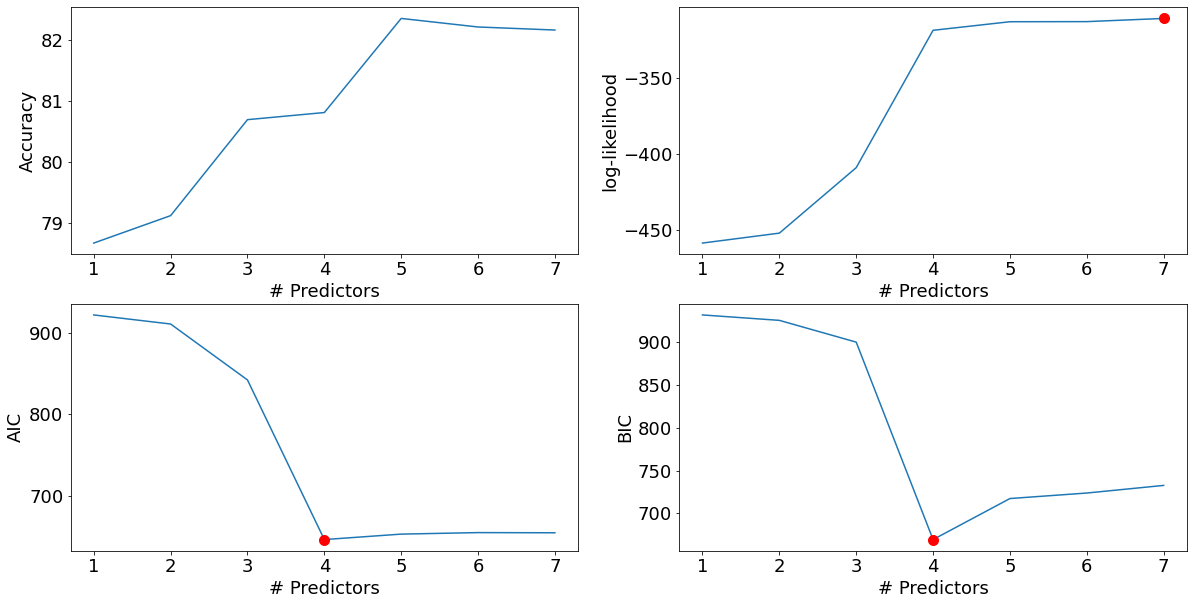

In [60]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
    
    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)
    
    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(best_models["accuracy"])
    plt.xlabel('# Predictors')
    plt.ylabel('Accuracy')
    
    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    log_likelihood = best_models.apply(lambda row: row[1].llf, axis=1)
    plt.subplot(2, 2, 2)
    plt.plot(log_likelihood)
    plt.plot(1+log_likelihood.argmax(), log_likelihood.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('log-likelihood')
    
    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = best_models.apply(lambda row: row[1].aic, axis=1)
    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')
    
    bic = best_models.apply(lambda row: row[1].bic, axis=1)
    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

## Best Model so far:

In [61]:
best_models['model'][4].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3399
Time:                        12:57:18   Log-Likelihood:                -318.36
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.089e-69
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.6008      0.543     10.306      0.000       4.536       6.666
Sex[T.male]    -2.6235      0.215    -12.229      0.000      -3.044      -2.203
Age            -0.0444      0.008     -5.442      0.000      -0.060      -0.028
SibSp          -0.3761      0.121     -3.106      0.002      -0.613      -0.139
Pclass         -1.3174      0.141     -9.350      0.000      -1.594      -1.041
===============================================================================
"""

In [62]:
confusion_matrix_train(best_models['model'][4], 0.5)

(          Predicted 0  Predicted 1
 Actual 0        365.0         59.0
 Actual 1         78.0        212.0,
 80.812324929972)

In [63]:
best_models['model'][5].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3516
Time:                        12:57:19   Log-Likelihood:                -312.70
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.508e-64
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    5.5066      0.882      6.242      0.000       3.778       7.236
Sex[T.male]                                                 -2.6847      0.229    -11.745      0.000      -3.133      -2.237
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0615      0.569      0.108      0.914      -1.053       1.176
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7449      0.521      1.430      0.153      -0.276       1.765
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.3907      0.530     -0.738      0.461      -1.429       0.648
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.0719      0.507     -0.142      0.887      -1.066       0.922
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.5364      0.524      1.024      0.306      -0.491       1.563
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.5239      0.557      0.941      0.347      -0.567       1.615
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.1082      0.561     -0.193      0.847      -1.208       0.991
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.4170      0.615      0.678      0.498      -0.789       1.623
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.3007      0.666      0.452      0.651      -1.004       1.605
Age                                                         -0.0465      0.008     -5.503      0.000      -0.063      -0.030
SibSp                                                       -0.4337      0.149     -2.912      0.004      -0.726      -0.142
Pclass                                                      -1.3061      0.229     -5.707      0.000      -1.755      -0.858
============================================================================================================================
"""

In [64]:
confusion_matrix_train(best_models['model'][5], 0.5)

(          Predicted 0  Predicted 1
 Actual 0        368.0         56.0
 Actual 1         70.0        220.0,
 82.3529411764706)

In [65]:
# from best subset selection with both Fare and fare_binned as predictors
best_models['model'][6].summary()
# Accuracy = 82.633, Log-likelihood = -312.50

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      699
Method:                           MLE   Df Model:                           14
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3517
Time:                        12:57:19   Log-Likelihood:                -312.62
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 7.321e-64
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    5.4182      0.910      5.956      0.000       3.635       7.201
Sex[T.male]                                                 -2.6985      0.232    -11.648      0.000      -3.153      -2.244
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0441      0.571      0.077      0.938      -1.075       1.163
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7348      0.521      1.410      0.159      -0.287       1.756
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.3880      0.530     -0.732      0.464      -1.426       0.650
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.0506      0.511     -0.099      0.921      -1.051       0.950
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.5726      0.532      1.077      0.282      -0.470       1.615
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.5803      0.575      1.010      0.313      -0.546       1.707
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.0133      0.612     -0.022      0.983      -1.212       1.186
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.4950      0.646      0.766      0.443      -0.771       1.761
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.4051      0.718      0.565      0.572      -1.001       1.812
Age                                                         -0.0466      0.008     -5.506      0.000      -0.063      -0.030
SibSp                                                       -0.4347      0.149     -2.921      0.003      -0.726      -0.143
Parch                                                       -0.0561      0.145     -0.388      0.698      -0.339       0.227
Pclass                                                      -1.2680      0.248     -5.109      0.000      -1.754      -0.782
============================================================================================================================
"""

In [66]:
# Remove Fare from above model
logit_model = sm.logit(formula = 'Survived ~ Sex + fare_binned + Age + SibSp + Pclass',
                      data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.437956
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3516
Time:                        12:57:19   Log-Likelihood:                -312.70
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.508e-64
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    5.5066      0.882      6.242      0.000       3.778       7.236
Sex[T.male]                                                 -2.6847      0.229    -11.745      0.000      -3.133      -2.237
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0615      0.569      0.108      0.914      -1.053       1.176
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7449      0.521      1.430      0.153      -0.276       1.765
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.3907      0.530     -0.738      0.461      -1.429       0.648
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.0719      0.507     -0.142      0.887      -1.066       0.922
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.5364      0.524      1.024      0.306      -0.491       1.563
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.5239      0.557      0.941      0.347      -0.567       1.615
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.1082      0.561     -0.193      0.847      -1.208       0.991
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.4170      0.615      0.678      0.498      -0.789       1.623
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.3007      0.666      0.452      0.651      -1.004       1.605
Age                                                         -0.0465      0.008     -5.503      0.000      -0.063      -0.030
SibSp                                                       -0.4337      0.149     -2.912      0.004      -0.726      -0.142
Pclass                                                      -1.3061      0.229     -5.707      0.000      -1.755      -0.858
============================================================================================================================
"""

In [67]:
confusion_matrix_train(logit_model, 0.5)

(          Predicted 0  Predicted 1
 Actual 0        368.0         56.0
 Actual 1         70.0        220.0,
 82.3529411764706)

In [68]:
# Remove fare_binned and keep Fare from above model
logit_model = sm.logit(formula = 'Survived ~ Sex + Fare + Age + SibSp + Pclass',
                      data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.445424
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3405
Time:                        12:57:19   Log-Likelihood:                -318.03
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 7.608e-69
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.3899      0.603      8.940      0.000       4.208       6.571
Sex[T.male]    -2.6131      0.215    -12.160      0.000      -3.034      -2.192
Fare            0.0019      0.002      0.784      0.433      -0.003       0.007
Age            -0.0439      0.008     -5.372      0.000      -0.060      -0.028
SibSp          -0.3924      0.123     -3.187      0.001      -0.634      -0.151
Pclass         -1.2542      0.161     -7.775      0.000      -1.570      -0.938
===============================================================================
"""

In [69]:
confusion_matrix_train(logit_model, 0.5)

(          Predicted 0  Predicted 1
 Actual 0        364.0         60.0
 Actual 1         80.0        210.0,
 80.3921568627451)

In [70]:
# Add interaction Sex*fare_binned
logit_model = sm.logit(formula = 'Survived ~ Sex + fare_binned + Age + SibSp + Pclass + Sex*fare_binned',
                      data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.428829
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      691
Method:                           MLE   Df Model:                           22
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3651
Time:                        12:57:19   Log-Likelihood:                -306.18
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 2.846e-61
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                6.4395      1.352      4.764      0.000       3.790       9.089
Sex[T.male]                                                             -3.7933      1.210     -3.135      0.002      -6.165      -1.422
fare_binned[T.Interval(7.55, 7.854, closed='right')]                    -1.2266      1.217     -1.008      0.314      -3.612       1.159
fare_binned[T.Interval(7.854, 8.05, closed='right')]                    -0.6509      1.334     -0.488      0.626      -3.265       1.963
fare_binned[T.Interval(8.05, 10.5, closed='right')]                     -1.4895      1.195     -1.247      0.212      -3.831       0.852
fare_binned[T.Interval(10.5, 14.454, closed='right')]                   -0.5432      1.189     -0.457      0.648      -2.874       1.788
fare_binned[T.Interval(14.454, 21.679, closed='right')]                 -0.7779      1.175     -0.662      0.508      -3.082       1.526
fare_binned[T.Interval(21.679, 27.0, closed='right')]                   -0.1898      1.261     -0.151      0.880      -2.661       2.281
fare_binned[T.Interval(27.0, 39.688, closed='right')]                   -1.4847      1.223     -1.214      0.225      -3.881       0.912
fare_binned[T.Interval(39.688, 77.958, closed='right')]                  0.3892      1.429      0.272      0.785      -2.412       3.191
fare_binned[T.Interval(77.958, 512.329, closed='right')]                -0.0101      1.411     -0.007      0.994      -2.775       2.755
Sex[T.male]:fare_binned[T.Interval(7.55, 7.854, closed='right')]         1.8979      1.404      1.352      0.176      -0.854       4.649
Sex[T.male]:fare_binned[T.Interval(7.854, 8.05, closed='right')]         1.7120      1.468      1.167      0.243      -1.164       4.588
Sex[T.male]:fare_binned[T.Interval(8.05, 10.5, closed='right')]          1.5217      1.371      1.110      0.267      -1.165       4.208
Sex[T.male]:fare_binned[T.Interval(10.5, 14.454, closed='right')]        0.2439      1.359      0.180      0.858      -2.419       2.907
Sex[T.male]:fare_binned[T.Interval(14.454, 21.679, closed='right')]      2.0094      1.338      1.501      0.133      -0.614       4.632
Sex[T.male]:fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.7839      1.375      0.570      0.569      -1.912       3.480
Sex[T.male]:fare_binned[T.Interval(27.0, 39.688, closed='right')]        1.8309      1.339      1.367      0.172      -0.794       4.456
Sex[T.male]:fare_binned[T.Interval(39.688, 77.958, closed='right')]     -0.0841      1.504     -0.056      0.955      -3.032       2.864
Sex[T.male]:fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.1785      1.471      0.121      0.903      -2.706       3.063
Age                                                                     -0.0460      0.009

In [71]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        378.0         46.0
 Actual 1         81.0        209.0,
 82.21288515406162)

In [72]:
train['fare_binned'] = binned_fare = pd.qcut(train['Fare'], 10, retbins = True)[0]
logit_model = sm.logit(formula = 'Survived ~ Sex + fare_binned + Age + I(Age**(1/10)) + SibSp + Pclass',
                      data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.427919
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      699
Method:                           MLE   Df Model:                           14
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3665
Time:                        12:57:19   Log-Likelihood:                -305.53
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 7.783e-67
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   16.5670      3.327      4.980      0.000      10.046      23.088
Sex[T.male]                                                 -2.7941      0.236    -11.855      0.000      -3.256      -2.332
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0485      0.575      0.084      0.933      -1.078       1.175
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7746      0.524      1.478      0.139      -0.253       1.802
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.5447      0.542     -1.006      0.314      -1.606       0.517
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.1720      0.515     -0.334      0.738      -1.180       0.837
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.2566      0.541      0.475      0.635      -0.803       1.316
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.3167      0.568      0.558      0.577      -0.796       1.429
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.4411      0.579     -0.762      0.446      -1.575       0.693
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.3095      0.623      0.496      0.620      -0.912       1.531
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.1849      0.676      0.274      0.784      -1.139       1.509
Age                                                          0.0076      0.017      0.457      0.648      -0.025       0.040
I(Age ** (1 / 10))                                          -9.0157      2.560     -3.522      0.000     -14.033      -3.998
SibSp                                                       -0.5253      0.155     -3.391      0.001      -0.829      -0.222
Pclass                                                      -1.2907      0.233     -5.535      0.000      -1.748      -0.834
============================================================================================================================
"""

In [73]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        375.0         49.0
 Actual 1         76.0        214.0,
 82.49299719887955)

In [74]:
# Remove fare_binned, keep Age**1/10
logit_model = sm.logit(formula = 'Survived ~ Sex + Age + I(Age**(1/10)) + SibSp + Pclass',
                      data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.437156
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3528
Time:                        12:57:19   Log-Likelihood:                -312.13
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 2.190e-71
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             15.1361      3.016      5.018      0.000       9.224      21.048
Sex[T.male]           -2.6900      0.218    -12.324      0.000      -3.118      -2.262
Age                    0.0031      0.016      0.198      0.843      -0.028       0.034
I(Age ** (1 / 10))    -7.9271      2.414     -3.283      0.001     -12.659      -3.195
SibSp                 -0.4976      0.130     -3.826      0.000      -0.752      -0.243
Pclass                -1.2734      0.141     -9.015      0.000      -1.550      -0.997
======================================================================================
"""

In [75]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        372.0         52.0
 Actual 1         79.0        211.0,
 81.65266106442577)

In [76]:
logit_model = sm.logit(formula = 'Survived ~ Sex + fare_binned + np.log(Age) + SibSp + Pclass',
                      data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.427693
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3668
Time:                        12:57:20   Log-Likelihood:                -305.37
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.249e-67
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    7.6136      1.075      7.084      0.000       5.507       9.720
Sex[T.male]                                                 -2.7953      0.235    -11.914      0.000      -3.255      -2.335
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0493      0.574      0.086      0.932      -1.076       1.175
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7722      0.524      1.474      0.140      -0.254       1.799
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.5483      0.541     -1.014      0.310      -1.608       0.511
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.1723      0.514     -0.335      0.738      -1.180       0.836
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.2545      0.538      0.473      0.636      -0.800       1.309
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.3174      0.564      0.562      0.574      -0.789       1.424
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.4381      0.574     -0.764      0.445      -1.562       0.686
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.3088      0.622      0.496      0.620      -0.911       1.528
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.1846      0.675      0.273      0.785      -1.139       1.508
np.log(Age)                                                 -1.0229      0.167     -6.107      0.000      -1.351      -0.695
SibSp                                                       -0.5227      0.155     -3.379      0.001      -0.826      -0.220
Pclass                                                      -1.2900      0.230     -5.608      0.000      -1.741      -0.839
============================================================================================================================
"""

In [77]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        376.0         48.0
 Actual 1         76.0        214.0,
 82.63305322128852)

In [78]:
# Remove fare_binned, keep np.log(Age)
logit_model = sm.logit(formula = 'Survived ~ Sex + np.log(Age) + SibSp + Pclass',
                      data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.436945
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3531
Time:                        12:57:20   Log-Likelihood:                -311.98
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.916e-72
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.3262      0.766      9.569      0.000       5.826       8.827
Sex[T.male]    -2.6949      0.218    -12.381      0.000      -3.122      -2.268
np.log(Age)    -0.9577      0.162     -5.911      0.000      -1.275      -0.640
SibSp          -0.4988      0.129     -3.854      0.000      -0.753      -0.245
Pclass         -1.2627      0.134     -9.402      0.000      -1.526      -0.999
===============================================================================
"""

In [79]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        372.0         52.0
 Actual 1         80.0        210.0,
 81.5126050420168)

In [80]:
train_drop_fare_nan = train.dropna(subset=['Fare'])
logit_model = sm.logit(formula = 'Survived ~ Sex + fare_binned + np.log(Age) + SibSp + Pclass',
                      data = train_drop_fare_nan).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.427693
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.3668
Time:                        12:57:20   Log-Likelihood:                -305.37
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.249e-67
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    7.6136      1.075      7.084      0.000       5.507       9.720
Sex[T.male]                                                 -2.7953      0.235    -11.914      0.000      -3.255      -2.335
fare_binned[T.Interval(7.55, 7.854, closed='right')]         0.0493      0.574      0.086      0.932      -1.076       1.175
fare_binned[T.Interval(7.854, 8.05, closed='right')]         0.7722      0.524      1.474      0.140      -0.254       1.799
fare_binned[T.Interval(8.05, 10.5, closed='right')]         -0.5483      0.541     -1.014      0.310      -1.608       0.511
fare_binned[T.Interval(10.5, 14.454, closed='right')]       -0.1723      0.514     -0.335      0.738      -1.180       0.836
fare_binned[T.Interval(14.454, 21.679, closed='right')]      0.2545      0.538      0.473      0.636      -0.800       1.309
fare_binned[T.Interval(21.679, 27.0, closed='right')]        0.3174      0.564      0.562      0.574      -0.789       1.424
fare_binned[T.Interval(27.0, 39.688, closed='right')]       -0.4381      0.574     -0.764      0.445      -1.562       0.686
fare_binned[T.Interval(39.688, 77.958, closed='right')]      0.3088      0.622      0.496      0.620      -0.911       1.528
fare_binned[T.Interval(77.958, 512.329, closed='right')]     0.1846      0.675      0.273      0.785      -1.139       1.508
np.log(Age)                                                 -1.0229      0.167     -6.107      0.000      -1.351      -0.695
SibSp                                                       -0.5227      0.155     -3.379      0.001      -0.826      -0.220
Pclass                                                      -1.2900      0.230     -5.608      0.000      -1.741      -0.839
============================================================================================================================
"""

## Output test file

In [81]:
def var_transform(new_data):
    binned_fare = pd.qcut(train['Fare'], 10, retbins = True) #can modify model by changing # of bins
    bins = binned_fare[1] # get cutoffs for each bin
    new_data['fare_binned'] = pd.cut(new_data['Fare'], bins = bins)
    
    pclass_dummies = pd.get_dummies(new_data['Pclass'], drop_first = True)
    pclass_dummies.columns = ['Pclass_2', 'Pclass_3']
    new_data = pd.concat([new_data, pclass_dummies], axis=1)
    return new_data

In [82]:
final_train = pd.read_csv('train.csv')
final_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
final_train = var_transform(final_train)
final_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fare_binned,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(0.0, 7.55]",0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(39.688, 77.958]",0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(7.854, 8.05]",0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(39.688, 77.958]",0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(7.854, 8.05]",0,1


In [84]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [85]:
final_model = sm.logit(formula = 'Survived~Age+Pclass+Sex+SibSp+Age*Sex',
                      data = final_train).fit()

Optimization terminated successfully.
         Current function value: 0.438264
         Iterations 6


In [86]:
cutoff = 0.5

In [87]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [88]:
test = var_transform(test)
pred_values = final_model.predict(test)
test['pred_values'] = pred_values
test['Survived'] = np.where(test['pred_values'] < cutoff, 0, 1)

In [89]:
test[['PassengerId', 'Survived']].to_csv('submission10.csv', index=False)

In [90]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fare_binned,Pclass_2,Pclass_3,pred_values,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,"(7.55, 7.854]",0,1,0.066824,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,"(0.0, 7.55]",0,1,0.437325,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,"(8.05, 10.5]",1,0,0.045616,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,"(8.05, 10.5]",0,1,0.103485,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,"(10.5, 14.454]",0,1,0.535617,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,"(7.854, 8.05]",0,1,NaN,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,"(77.958, 512.329]",0,0,0.948723,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,"(0.0, 7.55]",0,1,0.052592,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,"(7.854, 8.05]",0,1,NaN,1
